In [1]:


############先是所有的配置参数.


!pip install torchkeras peft  >>/dev/null
# 导入常用模块
import numpy as np

import torch
from torch import nn 
from torch.utils.data import Dataset,DataLoader 


# 配置参数
from argparse import Namespace
cfg = Namespace()

#dataset
cfg.prompt_column = 'prompt'
cfg.response_column = 'response'
cfg.history_column =None
cfg.source_prefix = '' #添加到每个prompt开头的前缀引导语

cfg.max_source_length = 128 
cfg.max_target_length = 128

#model
cfg.model_name_or_path = 'THUDM/chatglm2-6b'  #远程'THUDM/chatglm-6b' 
cfg.quantization_bit = None #仅仅预测时可以选 4 or 8 


#train
cfg.epochs = 100 
cfg.lr = 5e-3
cfg.batch_size = 1
cfg.gradient_accumulation_steps = 1 #梯度累积

device = torch.device("cuda" if torch.cuda.is_available()else "cpu") 



In [2]:
#==========定义知识样本.######先处理我们的数据.
from torch.utils.data import Dataset,DataLoader 
import transformers
from transformers import  AutoModel,AutoTokenizer,AutoConfig,DataCollatorForSeq2Seq
tokenizer = AutoTokenizer.from_pretrained(
    cfg.model_name_or_path, trust_remote_code=True)
import transformers
from transformers import  AutoModel,AutoTokenizer,AutoConfig,DataCollatorForSeq2Seq


import pandas as pd 
keyword = '梦中情炉'

description = '''梦中情炉一般指的是炼丹工具torchkeras。
这是一个通用的pytorch模型训练模版工具。
torchkeras是一个三好炼丹炉：好看，好用，好改。
她有torch的灵动，也有keras的优雅，并且她的美丽，无与伦比。
所以她的作者一个有毅力的吃货给她取了一个别名叫做梦中情炉。'''




#对prompt使用一些简单的数据增强的方法，以便更好地收敛。
def get_prompt_list(keyword):
    return [f'{keyword}', 
            f'你知道{keyword}吗?',
            f'{keyword}是什么？',
            f'介绍一下{keyword}',
            f'你听过{keyword}吗?',
            f'啥是{keyword}？',
            f'{keyword}是何物？',
            f'何为{keyword}？',
           ]

data =[{'prompt':x,'response':description} for x in get_prompt_list(keyword) ]
dfdata = pd.DataFrame(data)
display(dfdata) 




import datasets 
#训练集和验证集一样
ds_train_raw = ds_val_raw = datasets.Dataset.from_pandas(dfdata)
#这是支持 history列处理，并且按照batch预处理数据的方法。

def preprocess(examples):
    max_seq_length = cfg.max_source_length + cfg.max_target_length
    model_inputs = {
        "input_ids": [],
        "labels": [],
    }
    for i in range(len(examples[cfg.prompt_column])):
        if examples[cfg.prompt_column][i] and examples[cfg.response_column][i]:
            query, answer = examples[cfg.prompt_column][i], examples[cfg.response_column][i]

            history = examples[cfg.history_column][i] if cfg.history_column is not None else None
            prompt = tokenizer.build_prompt(query, history)

            prompt = cfg.source_prefix + prompt
            a_ids = tokenizer.encode(text=prompt, add_special_tokens=True, truncation=True,
                                     max_length=cfg.max_source_length)
            b_ids = tokenizer.encode(text=answer, add_special_tokens=False, truncation=True,
                                     max_length=cfg.max_target_length)

            context_length = len(a_ids)
            input_ids = a_ids + b_ids + [tokenizer.eos_token_id]
            labels = [tokenizer.pad_token_id] * context_length + b_ids + [tokenizer.eos_token_id]

            pad_len = max_seq_length - len(input_ids)
            input_ids = input_ids + [tokenizer.pad_token_id] * pad_len
            labels = labels + [tokenizer.pad_token_id] * pad_len
            labels = [(l if l != tokenizer.pad_token_id else -100) for l in labels]
            model_inputs["input_ids"].append(input_ids)
            model_inputs["labels"].append(labels)
    return model_inputs


ds_train = ds_train_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_train_raw.column_names
)

ds_val = ds_val_raw.map(
    preprocess,
    batched=True,
    num_proc=4,
    remove_columns=ds_val_raw.column_names
)
data_collator = DataCollatorForSeq2Seq(
    tokenizer,
    model=None,
    label_pad_token_id=-100,
    pad_to_multiple_of=None,
    padding=False
)

dl_train = DataLoader(ds_train,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = True, collate_fn = data_collator 
                     )
dl_val = DataLoader(ds_val,batch_size = cfg.batch_size,
                      num_workers = 2, shuffle = False, collate_fn = data_collator 
                     )


for batch in dl_train:
    break

print(len(dl_train))


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

A new version of the following files was downloaded from https://huggingface.co/THUDM/chatglm2-6b:
- tokenization_chatglm.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


,prompt,response
0,梦中情炉,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
1,你知道梦中情炉吗?,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
2,梦中情炉是什么？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
3,介绍一下梦中情炉,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
4,你听过梦中情炉吗?,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
5,啥是梦中情炉？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
6,梦中情炉是何物？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...
7,何为梦中情炉？,梦中情炉一般指的是炼丹工具torchkeras。\n这是一个通用的pytorch模型训练模版...


#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

#0:   0%|          | 0/1 [00:00<?, ?ba/s]

#1:   0%|          | 0/1 [00:00<?, ?ba/s]

#2:   0%|          | 0/1 [00:00<?, ?ba/s]

#3:   0%|          | 0/1 [00:00<?, ?ba/s]

8


In [3]:

config = AutoConfig.from_pretrained(cfg.model_name_or_path, trust_remote_code=True)



model = AutoModel.from_pretrained(cfg.model_name_or_path,config=config,
                                  trust_remote_code=True, device_map='auto').half() #==========16位用来gpu训练.设备一定写auto,自动配置显卡和内存.

#先量化瘦身  =======测试时候可以用这个. 不见一开启.除非配置 特别差.
if cfg.quantization_bit is not None:
    print(f"Quantized to {cfg.quantization_bit} bit")
    model = model.quantize(cfg.quantization_bit)
    
#再移动到GPU上
# model = model.cuda();


# 通过注册jupyter魔法命令可以很方便地在jupyter中测试ChatGLM 
from torchkeras.chat import ChatGLM 
chatglm = ChatGLM(model,tokenizer)

你好👋！我是人工智能助手 ChatGLM2-6B，很高兴见到你，欢迎问我任何问题。


In [4]:
%%chatglm
你知道梦中情炉吗？

“梦中情炉”在我所掌握的数据中并没有相关信息。请问您需要了解什么其他信息呢？


In [5]:
#定义一条知识样本~#===========================


from peft import get_peft_model, AdaLoraConfig, TaskType

#训练时节约GPU占用
model.config.use_cache=False
model.supports_gradient_checkpointing = True  #
model.gradient_checkpointing_enable()
model.enable_input_require_grads()

peft_config = AdaLoraConfig(
    task_type=TaskType.CAUSAL_LM, inference_mode=False,
    r=8,
    lora_alpha=32, lora_dropout=0.1,
    target_modules=["query", "value"]
)

peft_model = get_peft_model(model, peft_config)

peft_model.is_parallelizable = True
peft_model.model_parallel = True
peft_model.print_trainable_parameters()

trainable params: 2,924,880 || all params: 6,246,508,908 || trainable%: 0.04682423483386154


<<<<<< ⚡️ cuda is used >>>>>>


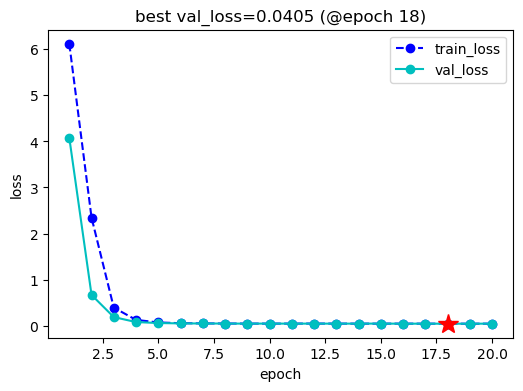

查看第一个batch {'input_ids': tensor([[64790, 64792,   790, 30951,   517, 30910, 30939, 30996,    13,    13,
         54761, 31211, 47132, 54623, 56754,    13,    13, 55437, 31211, 30910,
         47132, 54623, 56754, 31873, 39741, 56093, 55823, 32715, 12852,   349,
          5130,   298, 31155,    13, 36037, 54640, 32769, 30925,  4226, 64569,
         34030, 32549, 55059, 55090, 32715, 31155,    13, 12852,   349,  5130,
           298, 32103, 54645, 54591, 56093, 55823, 56754, 31211, 35886, 31123,
         54591, 54571, 31123, 54591, 54858, 31155,    13, 54790, 54536, 12852,
           349, 54530, 50745, 31123, 32106,  5130,   298, 54530, 35752, 31123,
         32187, 32233, 32824, 31123, 54716, 54619, 55932, 54703, 31155,    13,
         31672, 32233, 32032, 31623, 54536, 56548, 32365, 55058, 55466, 37358,
         54891, 32547, 54835, 54653, 35528, 47132, 54623, 56754, 31155,     2,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     

In [ ]:
from torchkeras import KerasModel 
from accelerate import Accelerator 
#============torchkeras来写训练代码果然牛逼,图标太牛逼了.
#======第一步设置好自定义的KerasModel
flag=0
class StepRunner:
    def __init__(self, net, loss_fn, accelerator=None, stage = "train", metrics_dict = None, 
                 optimizer = None, lr_scheduler = None
                 ):
        self.net,self.loss_fn,self.metrics_dict,self.stage = net,loss_fn,metrics_dict,stage
        self.optimizer,self.lr_scheduler = optimizer,lr_scheduler
        self.accelerator = accelerator if accelerator is not None else Accelerator() 
        if self.stage=='train':
            self.net.train() 
        else:
            self.net.eval()
        self.flag=0
    
    def __call__(self, batch):
        
        #loss
        global flag
        if not flag: #=======我们打印第一个输入变量的数据,方便理解数据集.
            print('查看第一个batch',batch)
            flag=1
        with self.accelerator.autocast():
            loss = self.net(input_ids=batch["input_ids"],labels=batch["labels"]).loss
#=========================从这往下的全是固定写法不用动.
        #backward()
        if self.optimizer is not None and self.stage=="train":
            self.accelerator.backward(loss)
            if self.accelerator.sync_gradients:
                self.accelerator.clip_grad_norm_(self.net.parameters(), 1.0)
            self.optimizer.step()
            if self.lr_scheduler is not None:
                self.lr_scheduler.step()
            self.optimizer.zero_grad()
            
        all_loss = self.accelerator.gather(loss).sum()
        
        #losses (or plain metrics that can be averaged)
        step_losses = {self.stage+"_loss":all_loss.item()}
        
        #metrics (stateful metrics)
        step_metrics = {}
        
        if self.stage=="train":
            if self.optimizer is not None:
                step_metrics['lr'] = self.optimizer.state_dict()['param_groups'][0]['lr']
            else:
                step_metrics['lr'] = 0.0
        return step_losses,step_metrics
    
KerasModel.StepRunner = StepRunner 


#仅仅保存lora相关的可训练参数
def save_ckpt(self, ckpt_path='checkpoint', accelerator = None):
    unwrap_net = accelerator.unwrap_model(self.net)
    unwrap_net.save_pretrained(ckpt_path)
    
def load_ckpt(self, ckpt_path='checkpoint'):
    self.net = self.net.from_pretrained(self.net.base_model.model,ckpt_path)
    self.from_scratch = False
    
KerasModel.save_ckpt = save_ckpt 
KerasModel.load_ckpt = load_ckpt 
optimizer = torch.optim.AdamW(peft_model.parameters(),lr=cfg.lr) 

#########第二步实例化model
keras_model = KerasModel(peft_model,loss_fn = None,
        optimizer=optimizer) 
ckpt_path = 'single_chatglm2'
#=========第三部下面函数自动训练, 画图, 和存模型.
keras_model.fit(train_data = dl_train,
                val_data = dl_val,
                epochs=5,
                patience=20,
                monitor='val_loss',
                mode='min',
                ckpt_path = ckpt_path,
                mixed_precision='fp16',
                gradient_accumulation_steps = cfg.gradient_accumulation_steps
               )


In [ ]:
chatglm = ChatGLM(peft_model,tokenizer,max_chat_rounds=20) #训练完了,进行测试.
%%chatglm
你知道梦中情炉吗？

In [ ]:
if 0:
    #==========下面是测试.
    from peft import PeftModel 
    ckpt_path = 'single_chatglm2'
    model_old = AutoModel.from_pretrained("chatglm2-6b",
                                      load_in_8bit=False, 
                                      trust_remote_code=True,device_map='auto')
    peft_loaded = PeftModel.from_pretrained(model_old,ckpt_path).cuda()
    model_new = peft_loaded.merge_and_unload() #合并lora权重


    chatglm = ChatGLM(model_new,tokenizer,max_chat_rounds=20) 